<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/Object_Localization_CV/blob/main/Object_localization_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-zvb117ph
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-zvb117ph
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 31.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 38.89 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
import sys
sys.path.append('/content/object-localization-dataset')

In [24]:
#Configs:
CSV_PATH = "/content/object-localization-dataset/train.csv"
DATA_DIR = "/content/object-localization-dataset/"

DEVICE = "cuda"
BATCH_SIZE = 16
IMG_SIZE = 140
LR = 0.001
EPOCHS = 40
NUM_COR = 4

MODEL_NAME = "efficientnet_b0"

In [6]:
df = pd.read_csv(CSV_PATH)

In [7]:
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


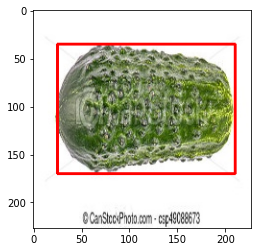

In [13]:
row = df.iloc[19]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [14]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
#Augmentation:
import albumentations as A

In [25]:
train_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

val_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [26]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentation=None):
    self.df = df
    self.augmentation = augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]
    img = cv2.imread(DATA_DIR + row.img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentation:
      data = self.augmentation(image=img, bboxes= bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]
    
    img = torch.from_numpy(img).permute(2, 0, 1)/ 255.0
    bbox = torch.Tensor(bbox)

    return img, bbox



In [27]:
train_set = ObjLocDataset(train_df, train_aug)
val_set = ObjLocDataset(val_df, val_aug)

In [28]:
len(train_set), len(val_set)

(148, 38)

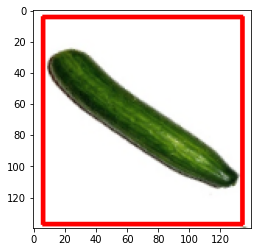

In [29]:
img, bbox = train_set[70]
xmin, ymin, xmax, ymax = bbox
pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))
bnd_box_img = cv2.rectangle(img.permute(1,2,0).numpy(), pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [34]:
#Loaders:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_set, batch_size= BATCH_SIZE, shuffle = True)
valloader = DataLoader(val_set, batch_size= BATCH_SIZE, shuffle = False)

In [35]:
len(trainloader), len(valloader)

(10, 3)

In [36]:
for images, bboxes in trainloader:
  break;

images.shape, bboxes.shape

(torch.Size([16, 3, 140, 140]), torch.Size([16, 4]))

In [37]:
#Create Model:
from torch import nn
import timm

In [49]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes

In [50]:
model = ObjLocModel()
model.to(DEVICE) 

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [51]:
model(torch.rand(1, 3, 140, 140).to(DEVICE)).shape

torch.Size([1, 4])

In [52]:
#Create Training and Evaluation funcs:

def train_func(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
    optimizer.zero_grad()
    bboxes, loss = model(images, gt_bboxes)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
  
  return total_loss/len(dataloader)


In [53]:
def eval_func(model, dataloader):
  total_loss = 0.0
  model.eval()

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
    bboxes, loss = model(images, gt_bboxes)
    total_loss += loss.item()
  
  return total_loss/len(dataloader)


In [54]:
#Training:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [55]:
best_val_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_func(model, trainloader, optimizer)
  val_loss = eval_func(model, valloader)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model saved!")
    best_val_loss = val_loss

  print(f"Epoch={i+1}, train_loss= {train_loss}, val_loss={val_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=1, train_loss= 5103.213549804687, val_loss=2119.481974283854


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=2, train_loss= 1828.2524047851562, val_loss=1697.4930419921875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=3, train_loss= 1094.9036987304687, val_loss=309.7886555989583


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=4, train_loss= 760.1385925292968, val_loss=281.6718343098958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=5, train_loss= 476.3126159667969, val_loss=183.62191772460938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=6, train_loss= 361.5609466552734, val_loss=182.8889897664388


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=7, train_loss= 285.5304641723633, val_loss=192.19166564941406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=8, train_loss= 194.29214782714843, val_loss=151.33606465657553


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=9, train_loss= 204.92315673828125, val_loss=168.3810577392578


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=10, train_loss= 143.6819091796875, val_loss=139.4925333658854


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=11, train_loss= 138.47863540649413, val_loss=119.5978775024414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=12, train_loss= 102.99550552368164, val_loss=122.1908696492513


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=13, train_loss= 98.63816032409667, val_loss=96.47213999430339


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=14, train_loss= 96.27157592773438, val_loss=88.5092544555664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=15, train_loss= 98.89081268310547, val_loss=136.27784729003906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=16, train_loss= 115.44375305175781, val_loss=95.09341176350911


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=17, train_loss= 85.67824859619141, val_loss=90.70144144694011


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=18, train_loss= 77.14132041931153, val_loss=110.23218282063802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=19, train_loss= 65.50809097290039, val_loss=98.12774658203125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=20, train_loss= 66.16143798828125, val_loss=76.6054178873698


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=21, train_loss= 61.51381072998047, val_loss=69.669740041097


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=22, train_loss= 65.57557239532471, val_loss=65.81188201904297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=23, train_loss= 63.092051315307614, val_loss=128.95335388183594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=24, train_loss= 57.26258563995361, val_loss=60.928077697753906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=25, train_loss= 63.35980033874512, val_loss=103.21907297770183


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=26, train_loss= 46.577125549316406, val_loss=72.48164749145508


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=27, train_loss= 53.252367210388186, val_loss=73.87849680582683


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=28, train_loss= 46.65994415283203, val_loss=69.55177942911784


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=29, train_loss= 54.08586158752441, val_loss=80.59888712565105


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=30, train_loss= 53.35156440734863, val_loss=74.4415054321289


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=31, train_loss= 46.435465812683105, val_loss=70.61405181884766


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=32, train_loss= 48.73835458755493, val_loss=59.070854822794594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=33, train_loss= 45.937691879272464, val_loss=81.58293151855469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=34, train_loss= 53.002740478515626, val_loss=83.9691556294759


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved!
Epoch=35, train_loss= 40.62693576812744, val_loss=56.57289123535156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=36, train_loss= 45.60904750823975, val_loss=80.52170944213867


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=37, train_loss= 43.05754699707031, val_loss=62.6531556447347


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=38, train_loss= 39.66809616088867, val_loss=64.3223139444987


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=39, train_loss= 66.89327011108398, val_loss=77.77405548095703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch=40, train_loss= 35.663876342773435, val_loss=67.87062327067058


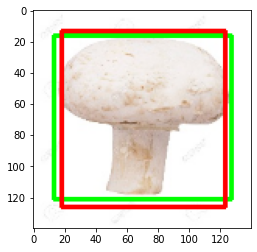

In [62]:
#Inference:
import utils

model.load_state_dict(torch.load('best_model.pt'))
model.eval()

image, gt_bbox = val_set[1]
image = image.unsqueeze(0).to(DEVICE)
bbox = model(image)

utils.compare_plots(image, gt_bbox, bbox)
